# Cian flats EDA

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import babel.numbers
import json

import seaborn as sns

# USE THIS STYLE
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# 
# OR THIS STYLE
import aquarel

import warnings

warnings.filterwarnings("ignore")

theme = aquarel.load_theme("arctic_light")
theme.set_font(family="serif")
theme.apply()

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
custom_pallete = {
    "red": "#BF616A",
    "orange": "#D08770",
    "yellow": "#EBCB8B",
    "green": "#A3BE8C",
    "purple": "#B48EAD",
    "light_green": "#8FBCBB",
    "light_gray_blue": "#88C0D0",
    "light_blue": "#81A1C1",
    "blue": "#5E81AC",
}

## Load data

In [3]:
df_cian = pd.read_csv("./data/cian_houses_training.csv")
df_cian.head()

price    geo_lat    geo_lng             metro  floor  floor_count  \
0  18374400  55.802530  37.620945      Марьина Роща     34           49   
1   8170000  55.552637  37.337172  Аэропорт Внуково      2            5   
2  20206500  55.810466  37.624247      Алексеевская     34           37   
3  17119620  55.706597  37.632285          Тульская      6           20   
4   7550000  55.551456  37.339499       Филатов луг      2            5   

   square  living_square  kitchen_square  year  ...           house_type  \
0   38.28          11.80           10.23  2027  ...  Монолитно-кирпичный   
1   31.00          14.61           10.00  2021  ...              unknown   
2   28.50          21.40            7.62  2024  ...  Монолитно-кирпичный   
3   38.82          10.60           18.60  2024  ...           Монолитный   
4   30.00          15.00            9.00  2021  ...              unknown   

   heating breakdown accomodation_type   author room_count floor_ratio  \
0  unknown   unknown       Новостройка  КОРТРОС          1    0.693878   
1  unknown       Нет          Вторичка  unknown          1    0.400000   
2  unknown   unknown       Новостройка  КОРТРОС          1    0.918919   
3  unknown   unknown       Новостройка  unknown          1    0.300000   
4  unknown       Нет          Вторичка  unknown          1    0.400000   

  room_ratio  living_ratio  kitchen_ratio  
0      38.28      0.308255       0.267241  
1      31.00      0.471290       0.322581  
2      28.50      0.750877       0.267368  
3      38.82      0.273055       0.479134  
4      30.00      0.500000       0.300000  

[5 rows x 23 columns]

In [4]:
df_cian.shape

(6524, 23)

In [5]:
df_cian.isna().drop_duplicates()

price  geo_lat  geo_lng  metro  floor  floor_count  square  living_square  \
0  False    False    False  False  False        False   False          False   

   kitchen_square   year  ...  house_type  heating  breakdown  \
0           False  False  ...       False    False      False   

   accomodation_type  author  room_count  floor_ratio  room_ratio  \
0              False   False       False        False       False   

   living_ratio  kitchen_ratio  
0         False          False  

[1 rows x 23 columns]

Все необходимые поля заполнены. (Важно, т.к. решается задача регрессии)

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [7]:
y = df_cian["price"]
X = df_cian.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [8]:
numerical_features = [f for f in X_train.columns if X_train.dtypes[f] != 'object']
categorical_features = [f for f in X_train.columns if X_train.dtypes[f] == 'object']

numerical_features, categorical_features

(['geo_lat',
  'geo_lng',
  'floor',
  'floor_count',
  'square',
  'living_square',
  'kitchen_square',
  'year',
  'ceiling_height',
  'room_count',
  'floor_ratio',
  'room_ratio',
  'living_ratio',
  'kitchen_ratio'],
 ['metro',
  'finish_type',
  'view',
  'house_type',
  'heating',
  'breakdown',
  'accomodation_type',
  'author'])

In [9]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
)

## Dummy boostings

### XGBRegressor

In [10]:
# xgb_reg = XGBRegressor()
clf = make_pipeline(preprocessor, XGBRegressor())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(19805917.573096264, 0.8801134824752808)

In [11]:
# enc = OneHotEncoder()
# enc.fit(X_train[categorical_features])

# mticker.Locator.MAXTICKS = 2500

# sorted_idx = np.argsort(clf[1].feature_importances_)
# fig = plt.figure(figsize=(10, 80))
# plt.barh(range(len(sorted_idx)), clf[1].feature_importances_[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
# plt.title('lgbm_Feature Importance')
# plt.show()

### XGBRFRegressor

In [12]:
clf = make_pipeline(preprocessor, XGBRFRegressor())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(28621443.888888888, 0.8118948936462402)

In [13]:
# enc = OneHotEncoder()
# enc.fit(X_train[categorical_features])

# mticker.Locator.MAXTICKS = 2500

# sorted_idx = np.argsort(clf[1].feature_importances_)
# fig = plt.figure(figsize=(10, 80))
# plt.barh(range(len(sorted_idx)), clf[1].feature_importances_[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
# plt.title('lgbm_Feature Importance')
# plt.show()

### LGBMRegressor

In [14]:
clf = make_pipeline(preprocessor, LGBMRegressor())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 5219, number of used features: 140
[LightGBM] [Info] Start training from score 95052613.690362


(20135856.10737013, 0.8850941048911837)

In [15]:
# enc = OneHotEncoder()
# enc.fit(X_train[categorical_features])

# mticker.Locator.MAXTICKS = 2500

# sorted_idx = np.argsort(clf[1].feature_importances_)
# fig = plt.figure(figsize=(10, 80))
# plt.barh(range(len(sorted_idx)), clf[1].feature_importances_[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
# plt.title('lgbm_Feature Importance')
# plt.show()

### CatBoost

In [16]:
clf = make_pipeline(preprocessor, CatBoostRegressor(silent=True))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(19659118.254821736, 0.893700710987803)

## Tuning

In [17]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

kfold = KFold(n_splits=3, shuffle=False)

### Tuning XGB

In [18]:
# def objective(trial, data=X_train, target=y_train):

#     param = {
#         "subsample": 0.7,
#         "colsample_bytree": 0.75,
#         "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.3, 1.6),
#         "learning_rate": trial.suggest_float("learning_rate", 0.12, 0.14),
#         "reg_alpha": trial.suggest_float("reg_alpha", 8.0, 8.3),
#         "reg_lambda": trial.suggest_float("reg_lambda", 8.0, 8.3),
#         "max_depth": 12,
#         "max_leaves": trial.suggest_categorical(
#             "max_leaves",
#             [
#                 150,
#                 # 170,
#             ],
#         ),
#         "random_state": 42,
#     }

#     model = make_pipeline(preprocessor, XGBRegressor(**param))

#     model.fit(X_train, y_train)
# #     scores = cross_val_score(
# #         model, X_train, y_train, cv=kfold, scoring=make_scorer(r2_score)
# #     )
#     pred = model.predict(X_test)

#     # return np.mean(scores)
#     return r2_score(y_test, pred)

In [19]:
# # # Create an Optuna study with pruning
# study = optuna.create_study(direction="maximize")

# # # Perform the optimization with more trials
# study.optimize(objective, n_trials=100)

# # # Get the best hyperparameters
# best_params_xgb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_xgb)

# Best Hyperparameters for XGBoost:
# {
#     "subsample": 0.7,
#     "colsample_bytree": 0.75,
#     "max_depth": 12,

#     "scale_pos_weight": 1.4973413678243312,
#     "learning_rate": 0.13031729315385945,
#     "reg_alpha": 8.214229231359171,
#     "reg_lambda": 8.130800037130106,
#     "max_leaves": 150,
    
#     "random_state": 42,
# }

### Tuned XGB

In [20]:
params_xgb = {
    "subsample": 0.7,
    "colsample_bytree": 0.75,
    "max_depth": 12,

    "scale_pos_weight": 1.4973413678243312,
    "learning_rate": 0.13031729315385945,
    "reg_alpha": 8.214229231359171,
    "reg_lambda": 8.130800037130106,
    "max_leaves": 150,
    
    "random_state": 42,
}

clf_xgb = make_pipeline(preprocessor, XGBRegressor(**params_xgb))

clf_xgb.fit(
    X_train,
    y_train,
)

mean_absolute_error(y_test, clf_xgb.predict(X_test)), r2_score(y_test, clf_xgb.predict(X_test))

(16897867.61130268, 0.9196434617042542)

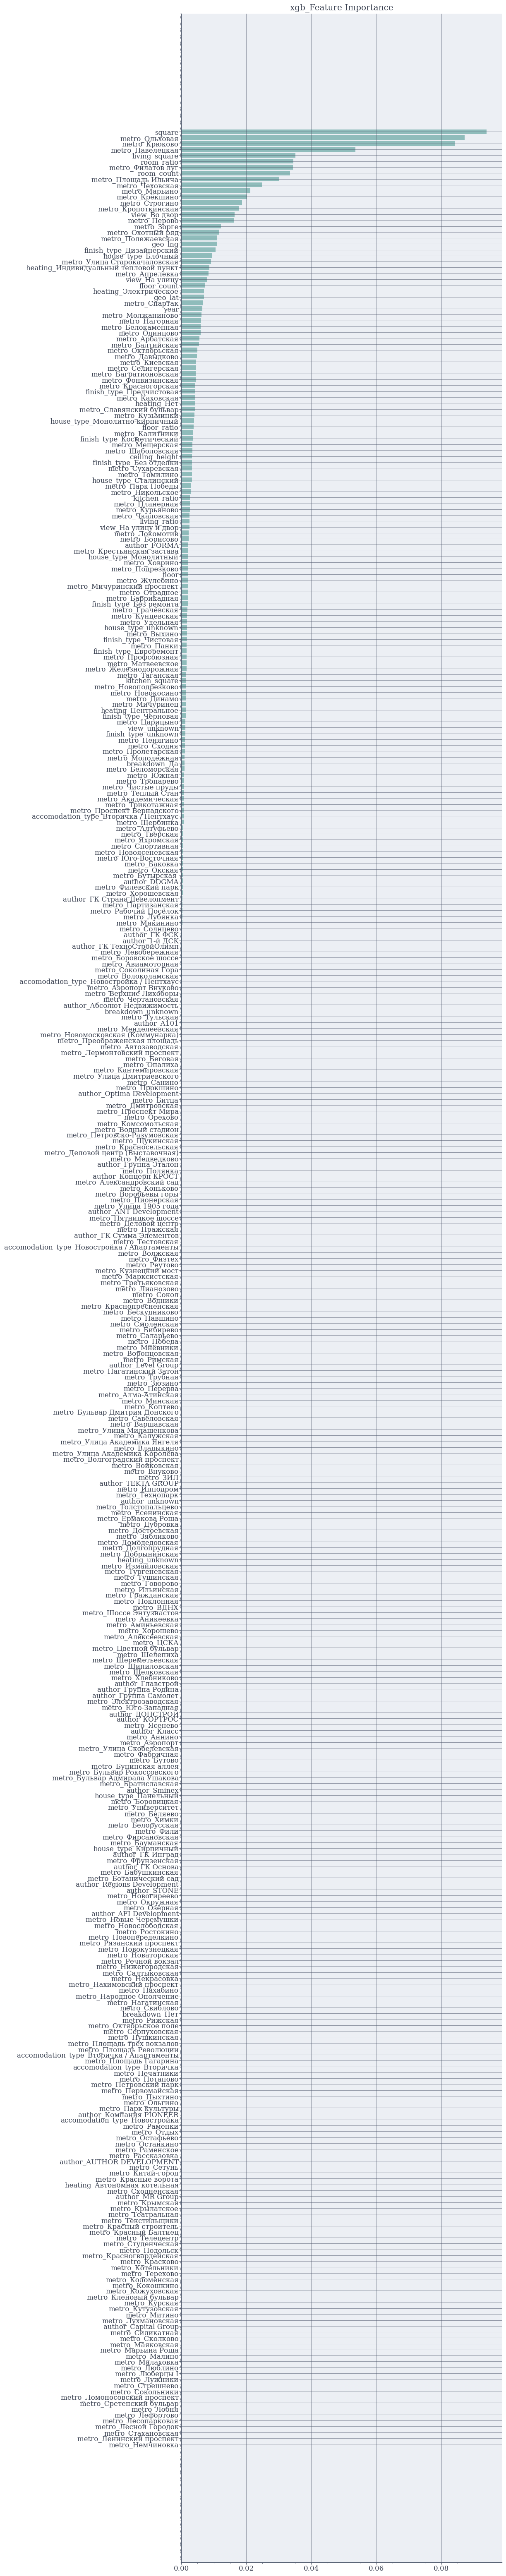

In [21]:
enc = OneHotEncoder()
enc.fit(X_train[categorical_features])

mticker.Locator.MAXTICKS = 2500

sorted_idx = np.argsort(clf_xgb[1].feature_importances_)
fig = plt.figure(figsize=(10, 80))
plt.barh(range(len(sorted_idx)), clf_xgb[1].feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
plt.title('xgb_Feature Importance')
plt.show()

### Tuning XGBRF 
> Unsuccessful 
>
> Не получилось нормально потюнить параметры

### Tuning LGB

In [22]:
# def objective(trial, data=X_train, target=y_train):

#     param = {
#         "objective": "regression",
#         "metric": "r2",

#         "subsample": 0.75,
#         "colsample_bytree": 0.535,

#         # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.52, 0.55),
#         # "subsample": trial.suggest_float("subsample", 0.7, 0.8),

#         "scale_pos_weight": 1.7, # trial.suggest_float("scale_pos_weight", 1.65, 1.8),
#         "n_estimators": trial.suggest_int("n_estimators", 300, 600),
#         "verbosity": -1,
#         "learning_rate": trial.suggest_float("learning_rate", 0.12, 0.135),

#         "reg_alpha": trial.suggest_float("reg_alpha", 7.2, 7.5),
#         "reg_lambda": trial.suggest_float("reg_lambda", 7.2, 7.5),
#         "max_depth": trial.suggest_categorical("max_depth", [12,15,17,20]),
#         # "num_leaves": trial.suggest_categorical(
#         #     "num_leaves",
#         #     [37, 39, 41, 43],
#         # ),
#         "max_leaves": trial.suggest_categorical(
#             "max_leaves",
#             [50],
#         ),
#         "min_child_samples": trial.suggest_int("min_child_samples", 1, 1),
#         "random_state": 42,
#     }

#     model = make_pipeline(preprocessor, LGBMRegressor(**param))

#     model.fit(X_train, y_train)
#     #     scores = cross_val_score(
#     #         model, X_train, y_train, cv=kfold, scoring=make_scorer(r2_score)
#     #     )
#     pred = model.predict(X_test)

#     # return np.mean(scores)
#     return r2_score(y_test, pred)



In [23]:
# # # Create an Optuna study with pruning
# study = optuna.create_study(direction="maximize")

# # # Perform the optimization with more trials
# study.optimize(objective, n_trials=100)

# # # Get the best hyperparameters
# best_params_lgb = study.best_params
# print("Best Hyperparameters for LGB:", best_params_lgb)

# # Best Hyperparameters for LGB:
# # {
# #     "subsample": 0.75,
# #     "colsample_bytree": 0.535,
# #     "scale_pos_weight": 1.7, 

# #     "n_estimators": 501,
# #     "learning_rate": 0.13473543057016707,
# #     "reg_alpha": 7.290351325928806,
# #     "reg_lambda": 7.472804907720953,
# #     "verbosity": -1,

# #     "max_depth": 12,
# #     "num_leaves": 43,
# #     "min_child_samples": 1,

# #     "random_state": 42,
# # }

### Tuned LGB

In [24]:
params_lgb = {
    "subsample": 0.75,
    "colsample_bytree": 0.535,
    "scale_pos_weight": 1.7,
    "n_estimators": 501,
    "learning_rate": 0.13473543057016707,
    "reg_alpha": 7.290351325928806,
    "reg_lambda": 7.472804907720953,
    "verbosity": -1,
    "max_depth": 12,
    "num_leaves": 43,
    "min_child_samples": 1,
    "random_state": 42,
}

clf_lgb = make_pipeline(preprocessor, LGBMRegressor(**params_lgb))

clf_lgb.fit(
    X_train,
    y_train,
)

mean_absolute_error(y_test, clf_lgb.predict(X_test)), r2_score(y_test, clf_lgb.predict(X_test))
# r2_score(y_test, clf_lgb.predict(X_test))

(16700234.924061483, 0.9142039654239236)

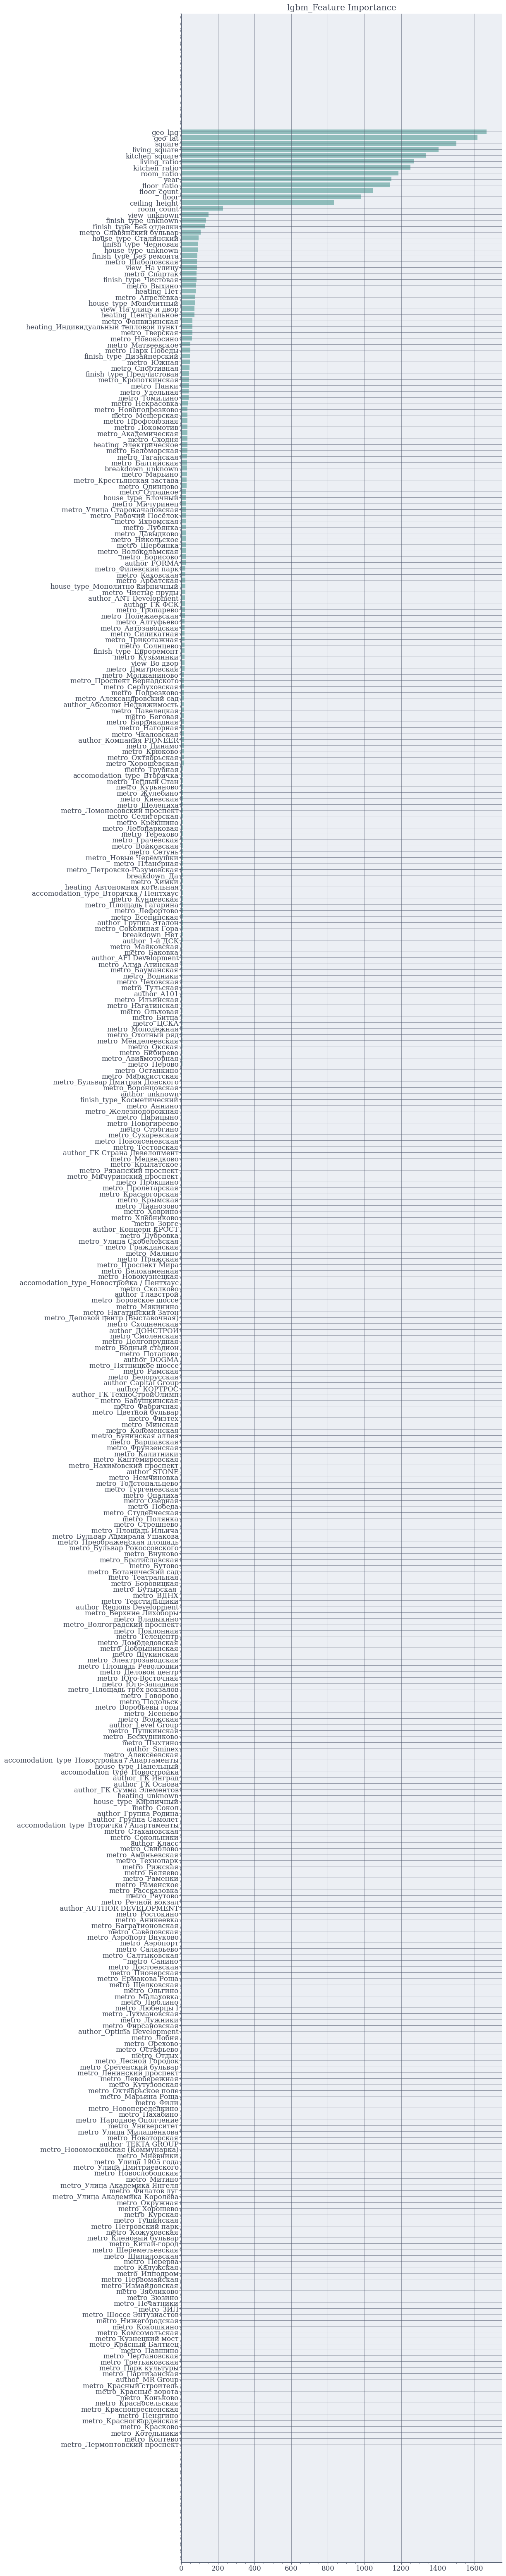

In [25]:
enc = OneHotEncoder()
enc.fit(X_train[categorical_features])

mticker.Locator.MAXTICKS = 2500

sorted_idx = np.argsort(clf_lgb[1].feature_importances_)
fig = plt.figure(figsize=(10, 80))
plt.barh(range(len(sorted_idx)), clf_lgb[1].feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
plt.title('lgbm_Feature Importance')
plt.show()

### Tuning CatBoost

CatBoost имеет входным параметром веса признаков, попробуем задать их в ручную

Т.к. данные проходят через кодирование, то порядок следования фитчей будет следующим.

In [26]:
enc = OneHotEncoder()
enc.fit(X_train[categorical_features])

np.array(list(numerical_features) + list(enc.get_feature_names_out()))[:10]

array(['geo_lat', 'geo_lng', 'floor', 'floor_count', 'square',
       'living_square', 'kitchen_square', 'year', 'ceiling_height',
       'room_count'], dtype='<U43')

Считаю важными фитчи 'geo_lat', 'geo_lng' &mdash; добавим им веса

In [27]:
weights = np.ones_like(np.array(list(numerical_features) + list(enc.get_feature_names_out())))
weights[0] = 5
weights[1] = 5
weights[:10]

array(['5', '5', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U43')

Подбор optuna

In [28]:
# def objective(trial):
#     params = {
#         "random_state": 42,
#         "random_strength": 1,
#         "loss_function": "RMSE",
#         "eval_metric": "R2",
#         "subsample": 0.75,
#         "colsample_bylevel": 0.7,
#         "feature_weights": weights,
#         "grow_policy": "Lossguide",
#         "verbose": 0,
#         "iterations": trial.suggest_int("iterations", 135, 140),
#         "reg_lambda": trial.suggest_float("reg_lambda", 7.24, 7.25),
#         "depth": trial.suggest_categorical("depth", [14, 15, 16, 18, 20]),
#         "max_leaves": trial.suggest_int("max_leaves", 145, 150),
#         "learning_rate": trial.suggest_float("learning_rate", 0.12, 0.125),
#     }

#     # scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=make_scorer(f1_score))

#     # return np.mean(scores)

#     model = make_pipeline(
#         preprocessor,
#         CatBoostRegressor(
#             **params,
#             # silent=True,
#             # task_type="GPU",
#         ),
#     )

#     model.fit(X_train, y_train)
#     #     scores = cross_val_score(
#     #         model, X_train, y_train, cv=kfold, scoring=make_scorer(r2_score)
#     #     )
#     pred = model.predict(X_test)

#     # return np.mean(scores)
#     return r2_score(y_test, pred)


In [29]:
# # # Create an Optuna study with pruning
# study = optuna.create_study(direction="maximize")

# # # Perform the optimization with more trials
# study.optimize(objective, n_trials=20)

# # # Get the best hyperparameters
# best_params_cb = study.best_params
# print("Best Hyperparameters for LGB:", best_params_cb)
# {
#     "random_state": 42,
#     "random_strength": 1,
#     "loss_function": "RMSE",
#     "eval_metric": "R2",
#     "subsample": 0.75,
#     "colsample_bylevel": 0.7,
#     "feature_weights": weights,
#     "grow_policy": "Lossguide",
#     "verbose": 0,
#     "iterations": 136,
#     "reg_lambda": 7.206968512644227,
#     "depth": 14,
#     "max_leaves": 148,
#     "learning_rate": 0.12045968051158068,
# }

### Tuned CatBoost

In [30]:
params_cat = {
    "random_state": 42,
    "random_strength": 1,
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "subsample": 0.75,
    "colsample_bylevel": 0.7,
    "feature_weights": weights,
    "grow_policy": "Lossguide",
    "verbose": 0,
    "iterations": 136,
    "reg_lambda": 7.206968512644227,
    "depth": 14,
    "max_leaves": 148,
    "learning_rate": 0.12045968051158068,
}

clf_cat = make_pipeline(preprocessor, CatBoostRegressor(**params_cat))

clf_cat.fit(
    X_train,
    y_train,
)

mean_absolute_error(y_test, clf_cat.predict(X_test)), r2_score(y_test, clf_cat.predict(X_test))

(17089608.71585068, 0.914583807755554)

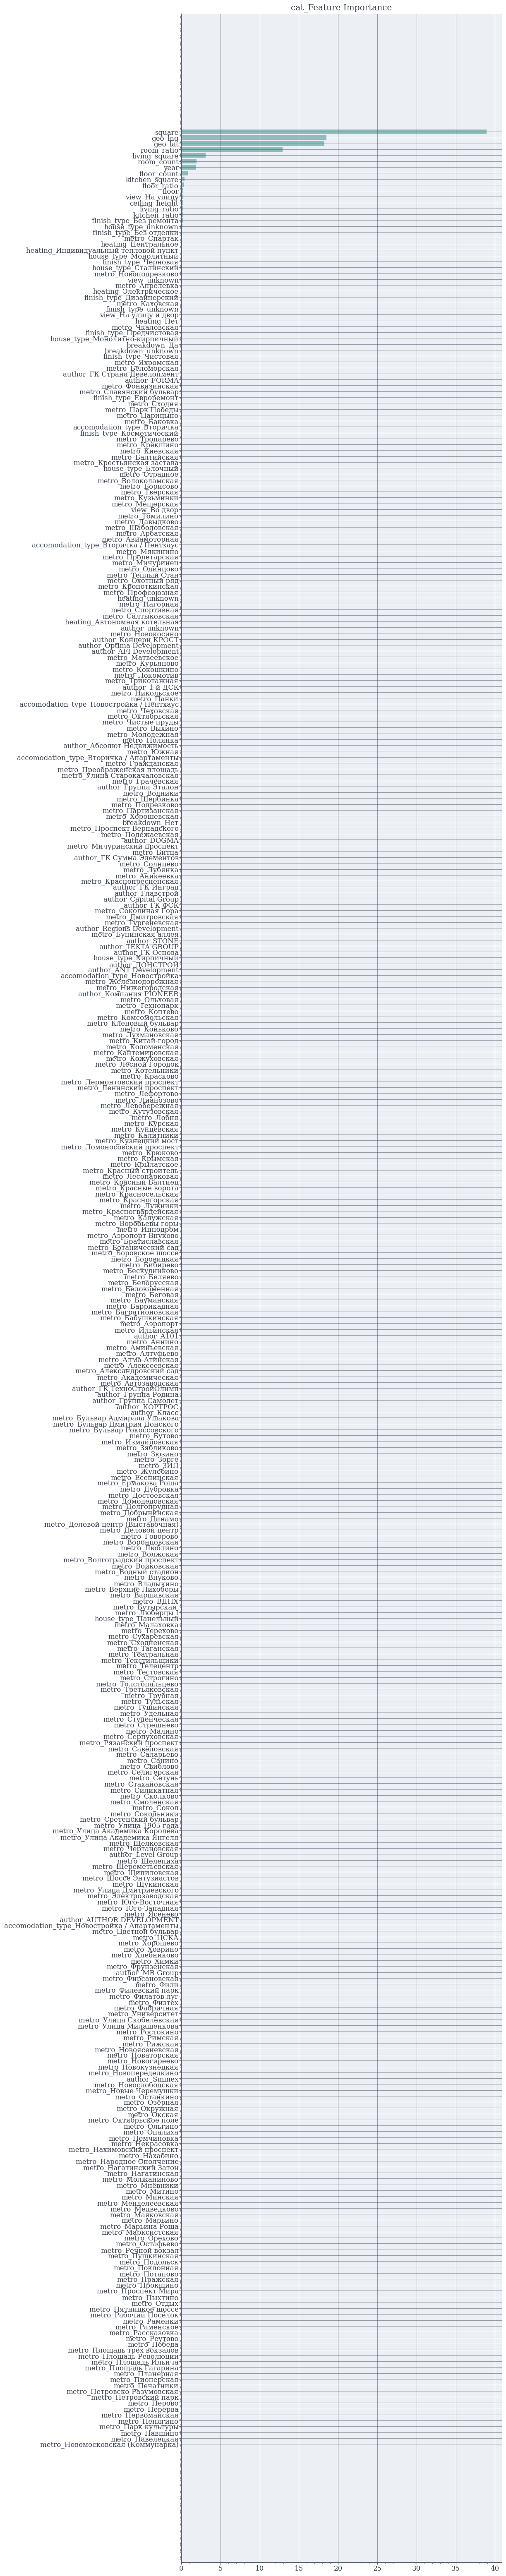

In [31]:
enc = OneHotEncoder()
enc.fit(X_train[categorical_features])

mticker.Locator.MAXTICKS = 2500

sorted_idx = np.argsort(clf_cat[1].feature_importances_)
fig = plt.figure(figsize=(10, 80))
plt.barh(range(len(sorted_idx)), clf_cat[1].feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(numerical_features) + list(enc.get_feature_names_out()))[sorted_idx])
plt.title('cat_Feature Importance')
plt.show()

## Ансамблирование моделей

In [32]:
from sklearn.ensemble import VotingRegressor

> Так же был опробован StackingRegressor, но его результат оказался хуже VotingRegressor

In [33]:
ensemble_model = make_pipeline(
    preprocessor,
    VotingRegressor(
        estimators=[
            ("xgb", XGBRegressor(**params_xgb)),
            ("lgb", LGBMRegressor(**params_lgb)),
            ("cat", CatBoostRegressor(**params_cat)),
        ],
        weights = (0.6, 0.2, 0.2),
        n_jobs=-1,
    ),
)

ensemble_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['geo_lat', 'geo_lng',
                                                   'floor', 'floor_count',
                                                   'square', 'living_square',
                                                   'kitchen_square', 'year',
                                                   'ceiling_height',
                                                   'room_count', 'floor_ratio',
                                                   'room_ratio', 'living_ratio',
                                                   'kitchen_ratio']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='igno...
                                              LGBMRegressor(colsample_bytree=0.535,
                                                            learning_rate=0.13473543057016707,
                                                            max_depth=12,
                                                            min_child_samples=1,
                                                            n_estimators=501,
                                                            num_leaves=43,
                                                            random_state=42,
                                                            reg_alpha=7.290351325928806,
                                                            reg_lambda=7.472804907720953,
                                                            scale_pos_weight=1.7,
                                                            subsample=0.75,
                                                            verbosity=-1)),
                                             ('cat',
                                              <catboost.core.CatBoostRegressor object at 0x7ddd201082f0>)],
                                 n_jobs=-1, weights=(0.6, 0.2, 0.2)))])

In [34]:
ensemble_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['geo_lat', 'geo_lng',
                                                   'floor', 'floor_count',
                                                   'square', 'living_square',
                                                   'kitchen_square', 'year',
                                                   'ceiling_height',
                                                   'room_count', 'floor_ratio',
                                                   'room_ratio', 'living_ratio',
                                                   'kitchen_ratio']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='igno...
                                              LGBMRegressor(colsample_bytree=0.535,
                                                            learning_rate=0.13473543057016707,
                                                            max_depth=12,
                                                            min_child_samples=1,
                                                            n_estimators=501,
                                                            num_leaves=43,
                                                            random_state=42,
                                                            reg_alpha=7.290351325928806,
                                                            reg_lambda=7.472804907720953,
                                                            scale_pos_weight=1.7,
                                                            subsample=0.75,
                                                            verbosity=-1)),
                                             ('cat',
                                              <catboost.core.CatBoostRegressor object at 0x7ddd201082f0>)],
                                 n_jobs=-1, weights=(0.6, 0.2, 0.2)))])

In [35]:
mean_absolute_error(y_test, ensemble_model.predict(X_test)), r2_score(
    y_test, ensemble_model.predict(X_test)
)

(15936751.622941835, 0.9222596044097281)